In [7]:
# Phase I: Bootstrap 기반 control limit 설계
# dsvm_phase1_control_limit.ipynb

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dsvm.arl_mcc import estimate_arl_for_h_mcc


ModuleNotFoundError: No module named 'dsvm'

In [ ]:
# 프로젝트 루트 및 결과 디렉토리 설정
THIS_NOTEBOOK = Path().resolve()
PROJECT_ROOT = THIS_NOTEBOOK.parent   # dsvm-dtw/
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
CONTROL_DIR = RESULTS_DIR / "control_limits"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
CONTROL_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RESULTS_DIR :", RESULTS_DIR)
print("TABLES_DIR  :", TABLES_DIR)
print("CONTROL_DIR :", CONTROL_DIR)

# 데이터셋 / 실험 설정
dataset = "ECG5000"
stream = "train_incontrol"
mode = "ecd"         
data_version = "original"
seed = 2025
m = 100               
target_arl0 = 20

# 병합이 완료된 bootstrap p_swk 파일 범위
rep_start = 0
rep_end = 1999   # 예: 0~199 → rep_0 ~ rep_199

PROJECT_ROOT: C:\Users\siam2\Desktop\dsvm-dtw
RESULTS_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results
TABLES_DIR  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables
CONTROL_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits


In [ ]:
# Phase I 데이터프레임 불러오기
file_name = (
    f"{dataset}_{stream}_p_swk_matrix_{mode}_{data_version}"
    f"({rep_start}~{rep_end})_bootstrap_seed{seed}_m={m}.csv"
)
file_path = TABLES_DIR / file_name

print("읽을 파일명:", file_name)
print("전체 경로  :", file_path)

# 't'를 index로 복구
df_pswk = pd.read_csv(file_path, index_col=0)
print("df_pswk.shape:", df_pswk.shape)
df_pswk.head()

읽을 파일명: ECG5000_train_incontrol_p_swk_matrix_ecd_original(0~1999)_bootstrap_seed2025_m=100.csv
전체 경로  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables\ECG5000_train_incontrol_p_swk_matrix_ecd_original(0~1999)_bootstrap_seed2025_m=100.csv
df_pswk.shape: (100, 2000)


,rep_0,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,...,rep_1990,rep_1991,rep_1992,rep_1993,rep_1994,rep_1995,rep_1996,rep_1997,rep_1998,rep_1999
t,,,,,,,,,,,,,,,,,,,,,
0,0.312332,0.323463,0.306399,0.309289,0.335372,0.300377,0.313861,0.301350,0.349176,0.318374,...,0.303508,0.323189,0.329241,0.312162,0.317995,0.292562,0.325938,0.318118,0.335195,0.332871
1,0.332562,0.325662,0.310543,0.325486,0.359059,0.364554,0.318680,0.314923,0.320030,0.300177,...,0.317522,0.315970,0.318004,0.293162,0.312119,0.291090,0.326876,0.330338,0.333566,0.310947
2,0.327800,0.309190,0.317350,0.336659,0.294071,0.329240,0.320845,0.327462,0.293317,0.300918,...,0.330570,0.306852,0.323306,0.310133,0.295365,0.337409,0.330454,0.316249,0.344175,0.298551
3,0.323778,0.303823,0.316186,0.300627,0.332271,0.320076,0.368687,0.326516,0.341175,0.318470,...,0.342380,0.328775,0.335488,0.310561,0.318040,0.312324,0.314894,0.327129,0.320961,0.305647
4,0.304548,0.335525,0.303125,0.299490,0.333386,0.316826,0.311057,0.317694,0.313583,0.297854,...,0.322843,0.328060,0.310203,0.324479,0.309609,0.332655,0.346126,0.341819,0.329778,0.344469


In [ ]:
p_swk_mat = df_pswk.values  # shape (m, outer_reps)

print("p_swk min :", p_swk_mat.min())
print("p_swk max :", p_swk_mat.max())

# 아주 넓은 구간에서 coarase grid
h_grid_coarse = np.linspace(p_swk_mat.min(), p_swk_mat.max(), 20)

rows = []
for h in h_grid_coarse:
    est = estimate_arl_for_h_mcc(h=h, p_swk_mat=p_swk_mat, m=m)
    rows.append({"h": h, "ARL0": est["arl"]})

df_scan = pd.DataFrame(rows)
df_scan


p_swk min : 0.2829620334656059
p_swk max : 0.4495940227279514


,h,ARL0
0,0.282962,1.000000
1,0.291732,1.016000
2,0.300502,1.143500
3,0.309272,1.713500
4,0.318042,3.632000
5,0.326813,10.263370
6,0.335583,27.027248
7,0.344353,56.943820
8,0.353123,113.970561
9,0.361893,209.418956


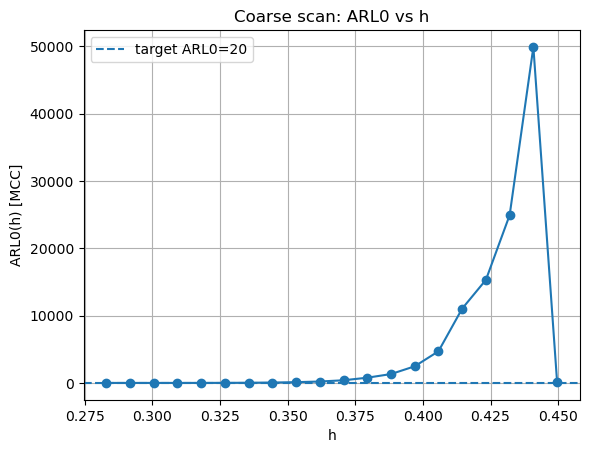

In [ ]:
plt.plot(df_scan["h"], df_scan["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Coarse scan: ARL0 vs h")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# diff = ARL0 - target
df_scan["diff"] = df_scan["ARL0"] - target_arl0
df_scan

,h,ARL0,diff
0,0.282962,1.000000,-19.000000
1,0.291732,1.016000,-18.984000
2,0.300502,1.143500,-18.856500
3,0.309272,1.713500,-18.286500
4,0.318042,3.632000,-16.368000
5,0.326813,10.263370,-9.736630
6,0.335583,27.027248,7.027248
7,0.344353,56.943820,36.943820
8,0.353123,113.970561,93.970561
9,0.361893,209.418956,189.418956


In [ ]:
brackets = []

for i in range(len(df_scan) - 1):
    h1, a1, d1 = df_scan.loc[i, ["h", "ARL0", "diff"]]
    h2, a2, d2 = df_scan.loc[i+1, ["h", "ARL0", "diff"]]

    # sign change 여부 확인
    if d1 == 0:
        brackets.append((h1, h1))
    elif d1 * d2 < 0:
        brackets.append((h1, h2))

brackets


[(0.32681255695569683, 0.335582661653715)]

In [ ]:
if len(brackets) == 0:
    print("경고: coarse grid에서 target ARL0를 가로지르는 구간을 찾지 못했습니다.")
    print("→ h 범위를 넓히거나, coarse grid 개수를 늘려서 다시 확인하는 게 좋습니다.")
    # 그래도 진행하고 싶다면, 그냥 전체 범위에서 best gap를 찾는 fallback을 만들 수도 있음
else:
    h_low, h_high = brackets[0]
    print(f"선택된 브래킷 구간: h_low = {h_low:.6f}, h_high = {h_high:.6f}")


선택된 브래킷 구간: h_low = 0.326813, h_high = 0.335583


In [ ]:
target_arl = target_arl0
tolerance = 0.01
max_iter = 50  # coarse 브래킷 안이므로 너무 많이 안 돌려도 됨

lower = h_low
upper = h_high

best_h = None
best_arl = None
best_gap = float('inf')
best_sdrl = None
best_se = None

for _ in range(max_iter):
    mid = (lower + upper) / 2
    res = estimate_arl_for_h_mcc(mid, p_swk_mat, m)
    est_arl = res['arl']
    gap = abs(est_arl - target_arl)

    if gap < best_gap:
        best_gap = gap
        best_h = mid
        best_arl = est_arl
        best_sdrl = res['sdrl']
        best_se = res['se']

    if gap < tolerance:
        break

    # ARL가 target보다 작으면 → threshold가 너무 낮은 것 → 더 크게
    if est_arl < target_arl:
        lower = mid
    else:
        upper = mid

print(f"\n✅ 최적 h ≈ {best_h:.6f}")
print(f"   추정 ARL0(h*) ≈ {best_arl:.3f} (target={target_arl})")
print(f"   SDRL(h*)      ≈ {best_sdrl:.3f}")
print(f"   SE[ARL0(h*)]  ≈ {best_se:.4f}")
print(f"   최종 gap      ≈ {best_gap:.4f}")



✅ 최적 h ≈ 0.332534
   추정 ARL0(h*) ≈ 19.987 (target=20)
   SDRL(h*)      ≈ 31.885
   SE[ARL0(h*)]  ≈ 0.7130
   최종 gap      ≈ 0.0131


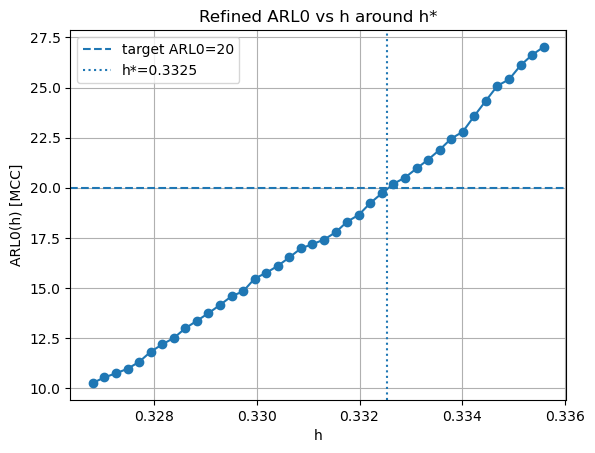

In [ ]:
# 브래킷 주변을 조금 더 촘촘하게 보자
h_fine = np.linspace(h_low, h_high, 40)
rows_fine = []
for h in h_fine:
    est = estimate_arl_for_h_mcc(h, p_swk_mat, m)
    rows_fine.append({"h": h, "ARL0": est["arl"]})

df_fine = pd.DataFrame(rows_fine)

plt.plot(df_fine["h"], df_fine["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.axvline(best_h, linestyle=":", label=f"h*={best_h:.4f}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Refined ARL0 vs h around h*")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import json

# h*만 npy로 저장
h_star = float(best_h)
h_star_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.npy"
np.save(h_star_path, np.array([h_star], dtype=float))
print("h* 저장 경로 (npy):", h_star_path)

# 메타정보 json 저장
meta = {
    "dataset": dataset,
    "stream": stream,
    "mode": mode,
    "data_version": data_version,
    "seed": seed,
    "m": m,
    "target_ARL0": target_arl0,
    "h_star": float(best_h),
    "ARL0_h_star": float(best_arl),
    "SDRL_h_star": float(best_sdrl),
    "SE_ARL0_h_star": float(best_se),
    "rep_start": int(rep_start),
    "rep_end": int(rep_end),
}

h_star_json_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.json"
with open(h_star_json_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("h* 메타정보 json 저장 경로:", h_star_json_path)


h* 저장 경로 (npy): C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_ecd_original_bootstrap_seed2025_m=100.npy
h* 메타정보 json 저장 경로: C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_ecd_original_bootstrap_seed2025_m=100.json


In [ ]:
# 추후 Phase II에서 사용할 때는 
# h_star = float(np.load(h_star_path))